In [1]:
''' This code implements the set of algorithms described in Section 5 from http://www.columbia.edu/~as5001/strategicclustering.pdf in order to find the next point in the fairness/utility-quality trade-off curve.'''
import networkx as nx
import csv 
import numpy as np
import random
import copy
import math 
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import pickle
import scipy

In [237]:
# the function cluster_proportions() computes the proportions of different communities in each cluster; 
# the community affiliation of a node is embedded in a graph attribute called 'color' ('b' for majority, 'r' for minority); for using the real data, embed as such.
def cluster_proportions(G, list_nodes_G, no_clusters, cluster_assignment):
    # sizes of clusters                                                                                                    
    unique, counts = np.unique(cluster_assignment, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    # cluster_proportion is a dictionary mapping from the clusters to the proportion of the majority nodes in each cluster 
    cluster_proportion = {}
    # cluster_majority is a dictionary mapping from the clusters to the number of the majority nodes in each cluster
    cluster_majority = {}
    # cluster_mminority is a dictionary mapping from the clusters to the number of the minority nodes in each cluster
    cluster_minority = {}
    for kk in range(no_clusters):
        cluster_proportion[kk] = 0
        cluster_majority[kk] = 0
        cluster_minority[kk] = 0

    for u in range(len(list_nodes_G)):
        if G.nodes[list_nodes_G[u]]['color'] == 'b':
            cluster_proportion[cluster_assignment[u]] += 1
            cluster_majority[cluster_assignment[u]] += 1
        else:
            cluster_minority[cluster_assignment[u]] += 1

    for kk in range(no_clusters):
        cluster_proportion[kk] /= cluster_sizes[kk]
    return cluster_sizes, cluster_proportion, cluster_majority, cluster_minority

# the function graph_communities() finds the ratio of majority and minority nodes in the graph
# the community affiliation of a node is embedded in a graph attribute called 'color' ('b' for majority, 'r' for minority); for using the real data, embed as such.
def graph_communities(G, list_nodes_G):
    maj_no = 0
    min_no = 0
    for u in range(len(list_nodes_G)):
        if G.nodes[list_nodes_G[u]]['color'] == 'b':
            maj_no += 1
        else:
            min_no += 1
    return maj_no, min_no


# the function compute_fairness_linear() computes a linear fairness metric defined as abs(#R in cluster - #B in cluster times (1-p)/p), where p = |B| / (|R| + |B|) in the general graph G
def compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = abs(cluster_minority[kk]- cluster_majority[kk]* (1 - maj_prop)/maj_prop)
 
    fairness_overall = np.sum(list(fairness_clusters.values()))
    fairness_overall = np.round(fairness_overall, 6)
    return fairness_clusters, fairness_overall



# the function compute_fairness_avgprop() computes the average fairness as defined by balance for a clustering as defined in https://proceedings.neurips.cc/paper_files/paper/2017/file/978fce5bcc4eccc88ad48ce3914124a2-Paper.pdf

def compute_balance_minprop(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    #[maj_no, min_no] = graph_communities(G, list_nodes_G)
    #maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = min(cluster_proportion[kk], 1 - cluster_proportion[kk])
 
    # fairness_overall = min(list(fairness_clusters.values()))
    fairness_overall = np.mean(list(fairness_clusters.values()))
    
    return fairness_clusters, fairness_overall


# the function compute_fairness_avgprop() computes the average fairness similar to balance for a clustering as defined in http://proceedings.mlr.press/v97/kleindessner19b.html (avg balance)
def compute_fairness_avgprop(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = abs(cluster_proportion[kk]- maj_prop)
 
    fairness_overall = np.mean(list(fairness_clusters.values()))
    return fairness_clusters, fairness_overall



# computing the incluster degree of nodes, helper function for compute_fairness_avgprop_mfhg and compute_util_avgprop_closeness
def incluster_degree(G, list_nodes_G, cluster_assignment, node):
    degu = 0
    for nbr in G.neighbors(node):
        if cluster_assignment[list_nodes_G.index(node)] == cluster_assignment[list_nodes_G.index(nbr)]:
            degu += 1
    return degu


# the function compute_fairness_avgprop_mfhg() computes the average utility as defined by mfu (https://www.semanticscholar.org/paper/Price-of-Pareto-Optimality-in-Hedonic-Games-Elkind-Fanelli/7764a4ee7d8e0a56c05439a429678d031ce601d4) 
# this utility function is mfu, from Price of Pareto Optimality in hedonic games by elkind et al, namely, w_i(C) / |C| - 1 (or w_i(C)/|C|) where w_i(C) is the sum of utility of node i in cluster C
def compute_util_avgprop_mfhg(G, list_nodes_G, no_clusters, cluster_assignment):
    util_clusters = {}
    for i in range(no_clusters):
        util_clusters[i] = 0
        # indices in cluster i
        cl = np.where(cluster_assignment == i)[0]
        for j in cl: 
            deg_u = incluster_degree(G, list_nodes_G, cluster_assignment, list_nodes_G[j])
            util_clusters[i] += deg_u/ (len(cl) - 1)
    util_overall = np.mean(list(util_clusters.values()))
    return util_clusters, util_overall

# the function compute_util_avgprop_closeness() computes the average utility as defined by the closeness utility, section 3 in http://www.columbia.edu/~as5001/strategicclustering.pdf
def compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment):
    util_clusters = {}
    for i in range(no_clusters):
        util_clusters[i] = 0
        # indices in cluster i
        cl = np.where(cluster_assignment == i)[0]
        for j in cl: 
            lengths_total = nx.single_source_shortest_path_length(G, list_nodes_G[j])
            deg_u = incluster_degree(G, list_nodes_G, cluster_assignment, list_nodes_G[j])
            lengths_j = 0
            for jj in cl:
                if j != jj:
                    lengths_j += lengths_total[list_nodes_G[jj]]
            util_clusters[i] += deg_u/lengths_j
    util_overall = np.mean(list(util_clusters.values()))
    return util_clusters, util_overall

# the function compute_conductance() computes average conductance for a clustering assignment (a metric for 'quality' of clustering in networks)
def compute_avg_conductance(G, list_nodes_G, no_clusters, cluster_assignment):
    conductance = 0
    conductance_clusters = {}
    
    for i in range(no_clusters):
        ll = np.where(cluster_assignment==i)[0].tolist()
        conductance_clusters[i] = nx.conductance(G, ll, list(set(list_nodes_G) - set(ll)))
    conductance = np.mean(list(conductance_clusters.values()))
    return conductance_clusters, conductance

# the function compute_avg_kdistance_cl() computes the average distance to the k-means center obtained from the kmeans algorithm for a specified cluster
# note: k-means doesn't optimize for average, this is just for our own experiments; in general, we use compute_avg_kdistance_cl_inertia defined below 
def compute_avg_kdistance_cl(cluster_assignment, my_cluster, km_distances):
    avgdist = km_distances[np.where(cluster_assignment==my_cluster)][:,my_cluster].mean()
    return avgdist

# the function compute_avg_kdistance() computes the average distance of all clusters to their respective k-means centers obtained from the kmeans algorithm
# note: k-means doesn't optimize for average, this is just for our own experiments; in general, we use compute_avg_kdistance_cl_inertia defined below 
def compute_avg_kdistance(cluster_assignment, no_clusters, km_distances):
    dist_clusters = {}
                                                                                                     
    for kkk in range(no_clusters):
        dist_clusters[kkk] = km_distances[np.where(cluster_assignment==kkk)][:,kkk].mean()
    avgdist = np.mean(list(dist_clusters.values()))
    return dist_clusters, avgdist

# the function compute_avg_kdistance_cl() computes the average distance to the k-means center obtained from the kmeans algorithm for a specified cluster
# note: this is what k-means optimizes for 
def compute_avg_kdistance_cl_inertia(cluster_assignmentx, my_cluster, km_distances):
    sumdist = km_distances[np.where(cluster_assignmentx==my_cluster)][:,my_cluster].sum()
    return sumdist

# the function compute_avg_kdistance() computes the average distance of all clusters to their respective k-means centers obtained from the kmeans algorithm
# note: this is what k-means optimizes for 
def compute_avg_kdistance_inertia(cluster_assignmentx, no_clusters, km_distances):
    dist_clusters = {}
                                                                                                     
    for kkk in range(no_clusters):
        dist_clusters[kkk] = (km_distances[np.where(cluster_assignmentx==kkk)][:,kkk]).sum()
    sumdist = np.sum(list(dist_clusters.values()))
    return dist_clusters, sumdist

# # the function compute_avg_ncut() computes the normalized cut size between a subgraph S and a graph G
def compute_avg_ncut(G, list_nodes_G, no_clusters, cluster_assignment):
    ncut = 0
    ncut_clusters = {}
                                                                                                    
    for i in range(no_clusters):
        ll = np.where(cluster_assignment==i)[0].tolist()
        ncut_clusters[i] = nx.normalized_cut_size(G, ll, list(set(list_nodes_G) - set(ll)))
    ncut = np.mean(list(ncut_clusters.values()))
    return ncut_clusters, ncut

def compute_centroids(G, list_nodes_G, no_clusters, cluster_assignment,myU):
    list_centroids = []
    for kk in range(no_clusters):
        list_centroids.append(myU[np.where(cluster_assignment==kk),:][0].mean(axis=0))
    return list_centroids
    
# the function doubly_weighted_G() creates a transformed doubly-weighted graph from an original inputted graph, where the weights represent the difference fairness/utility and quality, respectively.
def doubly_weighted_G(G,Gnew, list_nodes_G,cluster_assignment,no_clusters, km_distances):
    # use closeness utility
    #[fairness_cl, fairness_all] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
    # use statistical parity
    [fairness_cl, fairness_all] = compute_balance_minprop(G, list_nodes_G, no_clusters, cluster_assignment)
    [distances_cl, distances] = compute_avg_kdistance_inertia(cluster_assignment, no_clusters, km_distances)
    cc = copy.deepcopy(cluster_assignment)

    for u in range(len(list_nodes_G)):
        for v in range(len(list_nodes_G)):
            if cluster_assignment[u] != cluster_assignment[v]:
                cluster_assignment_copy = copy.deepcopy(cluster_assignment)
                mycl = cluster_assignment[v]
                # TODO: double check this, don't exchange them just compute the new clustering fairness/quality since you're changing the cluster assignment 
                # cluster_assignment_copy[u], cluster_assignment_copy[v] = cluster_assignment[v], cluster_assignment[u]
                cluster_assignment_copy[u] = copy.deepcopy(cluster_assignment[v]) 
                cluster_assignment_copy[v] = copy.deepcopy(cluster_assignment[u])

                # use closeness utility
                #[fairness_cl_new, fairness_all_new] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
                # use statistical parity
                [fairness_cl_new, fairness_all_new] = compute_balance_minprop(G, list_nodes_G, no_clusters, cluster_assignment_copy)
                distances_cl_new = compute_avg_kdistance_cl_inertia(cluster_assignment_copy, mycl, km_distances)

                # Gnew.add_edge(list_nodes_G[u],list_nodes_G[v],auv=(fairness_cl_new[mycl]-fairness_cl[mycl]),tuv=distances_cl_new-distances_cl[mycl])
                # NOTE: exchange the order, for balance instead of fairness 
                Gnew.add_edge(list_nodes_G[u],list_nodes_G[v],auv=(fairness_cl[mycl]-fairness_cl_new[mycl]),tuv=distances_cl_new-distances_cl[mycl])
                #cluster_assignment[u], cluster_assignment[v] = cluster_assignment[v], cluster_assignment[u]
    assert(cc == cluster_assignment).all()
    print('ok with the exchange')

    # adding edges from nodes to clusters
    cluster_nodes = list(range(len(G.nodes()),len(G.nodes()) + no_clusters))
    Gnew.add_nodes_from(cluster_nodes)
    for u in range(len(list_nodes_G)):
        for i in range(no_clusters):
            if cluster_assignment[u] != i:
                ucl = cluster_assignment[u]
                cluster_assignment[u] = i
                v = i + len(G.nodes())
                # use closeness utility
                #[fairness_cl_new, fairness_all_new] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
                # use statistical parity
                [fairness_cl_new, fairness_all_new] = compute_balance_minprop(G, list_nodes_G, no_clusters, cluster_assignment)
                distances_cl_new = compute_avg_kdistance_cl_inertia(cluster_assignment, i, km_distances)    
                # Gnew.add_edge(list_nodes_G[u],v,auv=(fairness_cl_new[i]-fairness_cl[i]),tuv=distances_cl_new-distances_cl[i])
                # NOTE: exchange the order, for balance instead of fairness            
                Gnew.add_edge(list_nodes_G[u],v,auv=(fairness_cl[i] - fairness_cl_new[i]),tuv=distances_cl_new-distances_cl[i])
                cluster_assignment[u] = ucl
    assert(cc == cluster_assignment).all()
    print('ok with the nodes to cluster edges')

    # adding edges from clusters to nodes if a node leaves its cluster 
    for u in range(len(list_nodes_G)):
        mycl2 = cluster_assignment[u]
        cluster_assignment[u] = (mycl2 + 1)%no_clusters
        v = mycl2 + len(G.nodes())
        [fairness_cl_new, fairness_all_new] = compute_balance_minprop(G, list_nodes_G, no_clusters, cluster_assignment)
        distances_cl_new = compute_avg_kdistance_cl_inertia(cluster_assignment, mycl2, km_distances)               
        # Gnew.add_edge(v,list_nodes_G[u],auv=(fairness_cl_new[mycl2]-fairness_cl[mycl2]),tuv=distances_cl_new-distances_cl[mycl2])
        # NOTE: exchange the order, for balance instead of fairness 
        Gnew.add_edge(v,list_nodes_G[u],auv=(fairness_cl[mycl2]- fairness_cl_new[mycl2]),tuv=distances_cl_new-distances_cl[mycl2])
        cluster_assignment[u] = mycl2
    assert(cc == cluster_assignment).all()
    print('ok with the cluster to nodes edges')

    # add node start 
    nn = len(Gnew.nodes())
    Gnew.add_node(nn)

    for j in cluster_nodes:
        Gnew.add_edge(j,nn,auv=0,tuv=0)
        Gnew.add_edge(nn,j,auv=0,tuv=0)
    assert(cc == cluster_assignment).all()
    print('ok with everything')


    # TODO: REMOVE THIS: not necessary to have an edge from start to every node
    # for j in range(len(G.nodes())):
        # add an edge from start node to every node with weight equal to the difference if we remove the node from its cluster
    #    mycl2 = cluster_assignment[j]
    #    cluster_assignment[j] = (mycl2 + 1)%no_clusters
        # use closeness utility
        #[fairness_cl_new2, fairness_all_new2] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
        # use statistical parity
    #    [fairness_cl_new2, fairness_all_new2] = compute_balance_minprop(G, list_nodes_G, no_clusters, cluster_assignment)
    #    distances_cl_new2 = compute_avg_kdistance_cl_inertia(cluster_assignment, mycl2, km_distances)
    #    Gnew.add_edge(nn,list_nodes_G[j],auv=(fairness_cl_new2[mycl2]-fairness_cl[mycl2]),tuv=distances_cl_new2-distances_cl[mycl2])
    #    cluster_assignment[j] = mycl2
    #for j in range(len(G.nodes()),nn):
    #    Gnew.add_edge(j,nn,auv=0,tuv=0)
    
    return Gnew

# this is the classic Floyd-Warshall algorithm for finding whether there is a negative cycle in t_uv weights
def negCyclefloydWarshall(G,list_nodes_G): 
    V = len(G.nodes())
    # dist[][] will be the 
    # output matrix that will  
    # finally have the shortest  
    # distances between every 
    # pair of vertices  
    #dist=[[0 for i in range(V+1)]for j in range(V+1)] 
    dist=[[0 for i in range(V)]for j in range(V)] 
       
    # Initialize the solution 
    # matrix same as input 
    # graph matrix. Or we can 
    # say the initial values  
    # of shortest distances 
    # are based on shortest  
    # paths considering no 
    # intermediate vertex.  
    for i in range(V): 
        for j in range(V): 
            if [list_nodes_G[i],list_nodes_G[j]] in G.edges():
                dist[i][j] = G[i][j]['tuv'] 
            else:
                dist[i][j] = math.inf
    ''' Add all vertices one 
        by one to the set of  
        intermediate vertices. 
    ---> Before start of a iteration, 
         we have shortest 
        distances between all pairs 
        of vertices such  
        that the shortest distances 
        consider only the 
        vertices in set {0, 1, 2, .. k-1} 
        as intermediate vertices. 
    ----> After the end of a iteration, 
          vertex no. k is  
        added to the set of 
        intermediate vertices and  
        the set becomes {0, 1, 2, .. k} '''
    for k in range(V): 
      
        # Pick all vertices  
        # as source one by one 
        for i in range(V): 
                   
            # Pick all vertices as 
            # destination for the 
            # above picked source 
            for j in range(V): 
          
                # If vertex k is on 
                # the shortest path from 
                # i to j, then update 
                # the value of dist[i][j] 
                if ((dist[i][k] + dist[k][j]) < dist[i][j]): 
                        dist[i][j] = dist[i][k] + dist[k][j] 
   
    # If distance of any 
    # vertex from itself 
    # becomes negative, then 
    # there is a negative 
    # weight cycle. 
    for i in range(V): 
        if (dist[i][i] < 0): 
            return True
   
    return False

# the function create_M_graph() creates a transformed graph with weights a_uv * M - t_uv
def create_M_graph(G,newG, theM):
    myG_M = nx.DiGraph()
    myG_M.add_nodes_from(G)
    auv_var=nx.get_edge_attributes(newG,'auv')
    tuv_var=nx.get_edge_attributes(newG,'tuv')
    for e in newG.edges():
        # note that it is auv + M * tuv, in order to make M positive
        myG_M.add_edge(e[0],e[1],weight=auv_var[e]+theM*tuv_var[e])
    return myG_M

# the function SPFA() implements a faster version of the Floyd-Warshall algorithm for finding negative cycles, without early termination and with cycle termination
def SPFA(G):
    queue = []
    length = {}
    dis = {}
    pre = {} 
    for v in G.nodes():
        length[v] = 0
        dis[v] = 0
        pre[v] = 0
        queue.append(v)
    while len(queue) > 0:
        u = queue.pop(0)
        for (u, v) in G.edges():
            if dis[u] + G[u][v]['weight'] < dis[v]:
                pre[v] = u
                length[v] = length[u] + 1
                if length[v] == len(G.nodes()):
                    return v,pre,"negative cycle detected"
                dis[v] = dis[u] + G[u][v]['weight']
                if v not in queue:
                    queue.append(v)
    return "no negative cycle detected"

# the function Trace() traces the negative cycle from the vertex given by SPFA
def Trace(pre, v):
    mys = []
    while v not in mys:
        mys.append(v)
        v = pre[v]
    cycle = [v]
    while mys[len(mys)-1] != v:
        cycle.append(mys.pop())
    cycle.append(v)
    return cycle

# the function compute_slope() computes the slope of line in Euclidean space
def compute_slope(x1, y1, x2, y2):
    return (float)(y2-y1)/(x2-x1)

# the function SPFA() implements a faster version of the Floyd-Warshall algorithm for finding negative cycles, without early termination and with cycle termination, used only for the t-weights
def SPFA2(G):
    length = {}
    dis = {}   
    pre = {} 
    queue = []
    for v in G.nodes():
        length[v] = 0
        dis[v] = 0
        pre[v] = 0
        queue.append(v)
    while len(queue) > 0:
        u = queue.pop(0)
        for (u, v) in G.edges():
            if dis[u] + G[u][v]['tuv'] < dis[v]:
                pre[v] = u
                length[v] = length[u] + 1
                if length[v] == len(G.nodes()):
                    return v,pre,"negative cycle detected"
                dis[v] = dis[u] + G[u][v]['tuv']
                if v not in queue:
                    queue.append(v)
    return "no negative cycle detected"

# the function compute_conductance() computes average conductance for a clustering assignment
def compute_conductance(G, list_of_nodes_G, cluster_assignment, no_of_clusters):
    clconductance = {}
    for i in range(no_of_clusters):
        icl = [list_of_nodes_G[x] for x in list(np.where(cluster_assignment == i)[0])]
        #print(icl)
        if len(icl) == 0 or len(icl) == len(list_of_nodes_G):
            clconductance[i] = 0
        else:
            clconductance[i] = nx.conductance(G,icl)
    if(len([v for v in clconductance.values() if v > 0]) == 0):
        return 0
    else:
        return 1 - sum(clconductance.values())/len([v for v in clconductance.values() if v > 0])

# the function compute_balance is computing average balance of a graph and a clustering as defined by balance for a clustering as defined in http://proceedings.mlr.press/v97/kleindessner19b.html (avg balance)
def compute_balance(G,list_of_nodes_G,cluster_assignment,no_of_clusters, sensitive_info):
   balance_avg = 0
   for cl in range(no_of_clusters):
       
       clind = np.where(cluster_assignment == cl)[0]
       sens0cl = 0
       sens1cl = 0
       for j in clind:
           if sensitive_info[j] == 0:
               sens0cl += 1
           else:
               sens1cl +=1
       if sens0cl == 0 or sens1cl == 0:
           balance_cl = 0
       else:
           balance_cl = min(sens0cl/sens1cl,sens1cl/sens0cl)
       balance_avg += balance_cl
   return balance_avg/no_of_clusters

# the function compute_balancemin is computing min balance of a graph and a clustering as defined by balance for a clustering as defined in http://proceedings.mlr.press/v97/kleindessner19b.html (avg balance)
def compute_balancemin(G,list_of_nodes_G,cluster_assignment,no_of_clusters, sensitive_info):
    balance_min = []
    for cl in range(no_of_clusters):
        clind = np.where(cluster_assignment == cl)[0]
        sens0cl = 0
        sens1cl = 0
        for j in clind:
            if sensitive_info[j] == 0:
                sens0cl += 1
            else:
                sens1cl +=1
        if sens0cl == 0 or sens1cl == 0:
            balance_cl = 0
        else:
            balance_cl = min(sens0cl/sens1cl,sens1cl/sens0cl)
        balance_min.append(balance_cl)
    return min(balance_min)


# this function is a Python-version of the Matlab code of the fair spectral clustering algorithm in http://proceedings.mlr.press/v97/kleindessner19b.html, used for comparing clustering with our own alg
def Fair_SC_normalized(G, adj,no_clusters,sensitive):
    n = np.shape(adj)[1]
    sens_unique = np.unique(sensitive)    
    h = len(sens_unique)
    sensitiveNEW=sensitive.copy()
    
    temp = 0
    
    for ell in sens_unique:
        sensitiveNEW[np.where(sensitive==ell)[0]] = temp
        temp += 1

    F=np.zeros([n,h-1])
    for ell in range(h-1):
        temp = np.where(sensitiveNEW == ell)[0]
        F[temp,ell]=1
        groupSize = len(temp)
        F[:,ell] = F[:,ell]-groupSize/n

    L = nx.normalized_laplacian_matrix(G)
    L.todense()
    D = np.diag(np.sum(np.array(adj.todense()), axis=1))

    _,Z = null(F.transpose())
    zz = ((Z.transpose()).dot(D)).dot(Z)
    Q = scipy.linalg.sqrtm(zz)
    Q = Q.real
    Qinv = np.linalg.inv(Q)
    
    Msymm = ((((Qinv.transpose()).dot(Z.transpose())).dot(L.todense())).dot(Z)).dot(Qinv)
    Msymm = (Msymm+Msymm.transpose())/2
    e,v = np.linalg.eig(Msymm)
    
    i = [list(e).index(j) for j in sorted(list(e))[1:no_clusters]]
    Y = np.array(v[:, i])
    Y = Y.real

    H = (Z.dot(Qinv)).dot(Y)
    
    km_fair = KMeans(init='k-means++', n_clusters=no_clusters, max_iter=200, n_init=200, verbose=0, random_state=3425)
    km_fair.fit(H)
    X_dist_fair = km_fair.transform(H)**2

    clusterLabels = km_fair.labels_
    return clusterLabels

def null(a, rtol=1e-5):
    u, s, v = np.linalg.svd(a)
    rank = (s > rtol*s[0]).sum()
    return rank, v[rank:].T.copy()

def compute_fairness_linear_x(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = cluster_minority[kk]- cluster_majority[kk]* (1 - maj_prop)/maj_prop
 
    #fairness_overall = np.sum(list(fairness_clusters.values()))
    return fairness_clusters

def compute_centroids_manually(U_matrix, cluster_assignment, no_of_clusters):
    new_centers = []
    for kk in range(no_of_clusters):
        kk_center = list(np.mean(U_matrix[np.where(cluster_assignment == kk)[0],:],axis=0))
        new_centers.append(kk_center)
    return new_centers
    
def compute_km_distances(points, centroids, no_of_clusters):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    
    X_dist_new = []
    for point in points: 
        zz = []
        for kk in range(no_of_clusters):
            zz.append(np.sum((point - centroids[kk])**2))
        X_dist_new.append(zz)
    return np.array(X_dist_new)

In [53]:
### the following section reads in one of the datasets: APS, Facebook, Highschool; uncomment for the data desired to use
'''#APS dataset: 
filename = 'APS-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
G_og = nx.read_gexf('Downloads/clustering_plotting/APS/sampled_APS_pacs052030.gexf')

# work with the largest connected compoenent
gg = sorted(nx.connected_components(G_og),key=len,reverse=True)[0]
Gc = G_og.subgraph(gg)

list_nodes=list(Gc.nodes())


# finding the spectrum of the graph
A = nx.adjacency_matrix(Gc)
L = nx.normalized_laplacian_matrix(Gc)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))
e, v = np.linalg.eig(L.todense())
'''

'''#Facebook dataset: 
filename = 'Facebook-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
Gc = nx.read_edgelist('Facebook/facebook_combined.txt')

list_nodes=list(Gc.nodes())

# finding the spectrum of the graph
A = nx.adjacency_matrix(Gc)
L = nx.normalized_laplacian_matrix(Gc)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))
e, v = np.linalg.eig(L.todense())

gender = {}
egos = ['0', '107','348','414','686','698','1684','1912','3437','3980']
genderfeatfinder = {}

# find the sensitive feaures (anonymized gender), and place them in a dictionary
for u in egos: 
    genderfeatfinder[u] = {}
    filenamefeat = 'Facebook/' + u + '.featnames'
    ffeat = open(filenamefeat)
    readerfeat = csv.reader(ffeat)
    for rowfeat in readerfeat:
        myrowfeat = rowfeat[0].split()
        genderfeatfinder[u][myrowfeat[0]] = myrowfeat[1].split(';')[0]
    ffeat.close()
    gender_ind = [k for k,v in genderfeatfinder[u].items() if v == 'gender']
    filenameego= 'Facebook/' + u +'.egofeat'
    fego = open(filenameego)
    readerego =csv.reader(fego)
    for rowego in readerego:
        myrowego = rowego[0].split()
        gender[u] = myrowego[int(max(gender_ind))]
    fego.close()
    filename= 'Facebook/' + u +'.feat'
    f = open(filename)
    reader =csv.reader(f)
    for row in reader:
        myrow = row[0].split()
        user = myrow[0]
        gender[user] = myrow[int(max(gender_ind))+1]
    f.close()

# create a list, sensitive[], that encodes the anonymized gender in the data; it is not used in this section
sensitive = []
for u in list_nodes:
    if (gender[u] == '1'):
        sensitive.append(1)
    else:
        sensitive.append(0)
sensitive = np.array(sensitive)
sensitive
'''

#Highschool dataset:
filename = 'Highschool-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
G_og = nx.read_edgelist('Friendship-network_data_2013.csv')

# get the largest connected component of the graph
gg = sorted(nx.connected_components(G_og),key=len,reverse=True)[0]
Gbig = G_og.subgraph(gg)
G_SBM = Gbig.copy()

# find the sensitive features (unanonymized gender) and place it in a dictionary
gender = {}

filename_read = 'metadata_2013.txt'
f = open(filename_read)
reader=csv.reader(f)

for row in reader:
    myrow = row[0].split('\t')
    gender[myrow[0]] = myrow[2]

list_init = list(G_SBM.nodes())
for u in list_init:
    if gender[u] == 'Unknown':
        G_SBM.remove_node(u)
        
# find the spectrum of the graph
list_nodes = list(G_SBM.nodes())

m = 0 
f = 0
d = {} 
for u in G_SBM.nodes():
    if gender[u] == 'M':
        d[u] = 'r'
        m += 1
    elif gender[u] == 'F':
        d[u] = 'b'
        f += 1
print('female: ', f)
print('male: ', m)

nx.set_node_attributes(G_SBM, d, name="color")



female:  76
male:  51


In [15]:
m/(f+m)

0.4015748031496063

In [8]:
# this code puts the sensitive attributes in a matrix; this is useful for comparing with the fair spectral clustering algorithm from http://proceedings.mlr.press/v97/kleindessner19b.html
sensitive = []
for u in list_nodes:
    if gender[u] == 'F':
        sensitive.append(1)
    else:
        sensitive.append(0)
sensitive = np.array(sensitive)

In [9]:
nx.info(G_SBM)

'Graph with 127 nodes and 396 edges'

## The next cell should be ran; loops through iterations while fixing negative cycles 

In [50]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 100
fairness_list = []
cost_list = []

# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)
print(y_copy)

iteration = 0

y_all = {}
print("Iteration number: ",iteration)
# compute the cost and fairness of this clustering
# using closeness utility
#[_,avgf] = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y)
# using statistical parity
[_,avgf] = compute_balance_minprop(G_SBM, list_nodes,k,y)
print("Balance: ", avgf)  

fairness_list.append(avgf)
[_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
print("Average cost: ", avgcost)
cost_list.append(avgcost)
#if avgf == 0:
#    break
# generating G_new with double weights
G_new = nx.DiGraph()
G_new.add_nodes_from(G_SBM)
G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
list_nodes_Gnew = list(G_new.nodes())

# length = {}
# dis = {}
# pre = {} 
result = SPFA2(G_new)

while iteration < no_of_iterations: 

  
    print("we're finding Mlow")

    Mfind = 1
    G_M = create_M_graph(G_SBM,G_new, Mfind)
    mresult = SPFA(G_M)
    if(len(mresult) != 3):
        Mfind = 0
        G_M = create_M_graph(G_SBM,G_new, Mfind)
        assert(len(SPFA(G_M)) == 3)
    else:
        while True:
            G_M = create_M_graph(G_SBM,G_new, Mfind)
            if SPFA(G_M) == 'no negative cycle detected':
                break
            Mfind *= 2

    # at this point, we perform a binary search 
    # initialize M and the limits for the binary search
    M = Mfind/2
    delta = Mfind/2
    low = Mfind/2
    high = Mfind

    # binary search to find M for which there is a cycle of length 0
    termination_condition = 10e-12
    mids = []
    while np.abs(delta) > termination_condition:
        if high > low: 
            mid = (high + low) / 2
            mids.append(mid)
        G_M = create_M_graph(G_SBM,G_new, mid)
        if SPFA(G_M) == 'no negative cycle detected':
            delta = mid - low
            high = mid
        else:
            delta = high - mid
            low = mid
        #print(delta)
    whereinmidsweare = 0
    for mm in reversed(mids):
        whereinmidsweare += 1
        G_M = create_M_graph(G_SBM,G_new, mm)
        if len(SPFA(G_M)) == 3:
            break
        if whereinmidsweare == len(mids):
            break
    M=mm

    G_M = create_M_graph(G_SBM,G_new, M)
    [v,pre,stri]=SPFA(G_M)
    # this is the best cycle that, if followed, will get us the next best clustering with the minimal ratio of cost loss to fairness/utility increase
    myc = Trace(pre,v)
    print("best cycle: ",myc)
    ytest = copy.deepcopy(y)

    myc2 = copy.deepcopy(myc)
    # we 'follow' the best cycle in order to find that next best clustering, and will compute the cost and fairness/utility as we start the loop again in the next iteration
    for i in range(len(myc)): 
        if type(myc[i]) == str:
            myc2[i] = list_nodes.index(myc[i])
    for i in range(len(myc2)):
        #print(myc2[i])
        if myc2[i] < len(G_SBM.nodes()):
            if i == len(myc2) - 1:
                break
            if myc2[i+1] < len(G_SBM.nodes()):
                #a = y[myc2[i]]
                ytest[myc2[i]] = y[myc2[i+1]]
            if myc2[i + 1] >= len(G_SBM.nodes()) and myc2[i+1] < len(G_SBM.nodes()) + k:
                #print(myc2[i+1])
                ytest[myc2[i]] = myc2[i+1] % len(G_SBM.nodes())
    y = copy.deepcopy(ytest)
    y_all[iteration] = y
    print("best cycle node indices: ", myc2)

    # sumcycle = 0
    t_weights = []
    a_weights = []
    for i in range(len(negt) - 1):
        # sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
        t_weights.append(G_new[myc[i]][myc[i+1]]['tuv'])
        a_weights.append(G_new[myc[i]][myc[i+1]]['auv'])
    print('cost weight of the best cycle: ', np.sum(t_weights), t_weights)
    print('balance weight of the best cycle: ', np.sum(a_weights), a_weights)

    iteration += 1

    # this is only for moving centroids 
    # new_centers = np.array(compute_centroids_manually(U, y,k))
    # X_dist = compute_km_distances(U,new_centers,k)
    
    [_,avgf] = compute_balance_minprop(G_SBM, list_nodes,k,y)
    print("Balance: ", avgf)  

    fairness_list.append(avgf)
    [_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
    print("Average cost: ", avgcost)
    cost_list.append(avgcost)
    # if avgf == 0:
    #     break
    # generating G_new with double weights
    G_new = nx.DiGraph()
    G_new.add_nodes_from(G_SBM)
    G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
    list_nodes_Gnew = list(G_new.nodes())

    # length = {}
    # dis = {}
    # pre = {} 
    result = SPFA2(G_new)

    if len(result) == 3:
        [vv,pre,stri] = result
        negt = Trace(pre,vv)
        print(negt)
        # compute the fairness and cost weights of the negative cycle that we find
        t_weights = []
        a_weights = []
        for i in range(len(negt) - 1):
            # sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
            t_weights.append(G_new[negt[i]][negt[i+1]]['tuv'])
            a_weights.append(G_new[negt[i]][negt[i+1]]['auv'])
        print('cost weight of the neg cycle: ', np.sum(t_weights), t_weights)
        print('balance weight of the neg cycle: ', np.sum(a_weights), a_weights)


        # alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration] - fairness_list[iteration - 1])
        alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration - 1] - fairness_list[iteration])
        alpha += 2e-2 # 2e-5
        print("neg cycle, alpha is ", alpha)
        # print("compute metric with alpha for C0: ", cost_list[iteration-1] + alpha*fairness_list[iteration - 1])
        # print("compute metric with alpha for C1: ", cost_list[iteration] + alpha*fairness_list[iteration])
        # this is for closeness utility when the metric goes up as we move down the pareto curve
        print("compute metric with alpha for C0: ", cost_list[iteration-1] - alpha*fairness_list[iteration - 1])
        print("compute metric with alpha for C1: ", cost_list[iteration] - alpha*fairness_list[iteration])
        for e in G_new.edges():
            # NOTE: this is - instead of + because we are maximizing balance instead of minizing fairness like before 
            G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
            G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)   
        
        newresult = SPFA2(G_new) 
        while len(newresult) == 3:
            [vv,pre,stri] = newresult
            negt = Trace(pre,vv)
            print(negt)
            sumcycle = 0
            t_weights_negt = []
            a_weights_negt = []
            for i in range(len(negt) - 1):
                sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
                t_weights_negt.append(G_new[negt[i]][negt[i+1]]['tuv'])
                a_weights_negt.append(G_new[negt[i]][negt[i+1]]['auv'])
            print("negative t-cycle was not fixed: ", sumcycle)
            print("neg cycle was not fixed, these are the weights: ", t_weights_negt, a_weights_negt)
            
            y_neg = copy.deepcopy(y)
            negt2 = copy.deepcopy(negt)
            for i in range(len(negt)): 
                if type(negt[i]) == str:
                    negt2[i] = list_nodes.index(negt[i])
            for i in range(len(negt2)):
                if negt2[i] < len(G_SBM.nodes()):
                    if i == len(negt2) - 1:
                        break
                    if negt2[i+1] < len(G_SBM.nodes()):
                        y_neg[negt2[i]] = y[negt2[i+1]]
                    if negt2[i + 1] >= len(G_SBM.nodes()) and negt2[i+1] < len(G_SBM.nodes()) + k:
                        y_neg[negt2[i]] = negt2[i+1] % len(G_SBM.nodes())

            # this is when we also update the centroids 
            # new_centers = np.array(compute_centroids_manually(U, y_neg,k))
            # X_dist = compute_km_distances(U,new_centers,k)
            
            _,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
            # using closeness utility
            #_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
            # using statistical parity
            _,avgfairnessneg = compute_balance_minprop(G_SBM, list_nodes,k,y_neg)
            print("Cost when correcting a negative cycle: ", avgdistneg)
            print("Balance when correcting a negative cycle: ", avgfairnessneg)
            print("compute metric for following the neg cycle: ", avgdistneg - alpha*avgfairnessneg)

            y = copy.deepcopy(y_neg)
            
            cost_list.append(avgdistneg)
            fairness_list.append(avgfairnessneg)
            iteration += 1 
            
            G_new = nx.DiGraph()
            G_new.add_nodes_from(G_SBM)
            G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)

            for e in G_new.edges():
                
                #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
                # NOTE: this is - instead of + because we are maximizing fairness instead of minimizing 
                G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
                G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)

            list_nodes_Gnew = list(G_new.nodes())
            newresult = SPFA2(G_new) # TODO: IS THIS THE ISSUE? 
            # need to update the iteration number 


[1, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]
Iteration number:  0
Balance:  0.3931888544891641
Average cost:  1.1903907713067448
we're finding Mlow
best cycle:  ['222', 128, 129, 127, '222']
best cycle node indices:  [106, 128, 129, 127, 106]
cost weight of the best cycle:  0.0007789029593255892 [0.00845833526800377, 0, 0, -0.00767943230867818]
balance weight of the best cycle:  -0.014391521790902584 [-0.010180995475113142, 0, 0, -0.004210526315789442]
Balance:  0.40038461538461534
Average cost:  1.1911696742660702
['222', 127, 129, 128, '222']
cost weight of the neg cycle:  -0.0007789029593255892 [0.00767943230867818, 0, 0, -0.00845833526800377]
balance weight of the neg cycle:  0.014391521790902584 [0.004210526315789442, 0, 0, 0.010180995475113142]
neg cycle, alpha i

KeyboardInterrupt: 

In [63]:
y[list_nodes.index('211')]

0

In [64]:
y_exchange = copy.deepcopy(y)

In [65]:
y_exchange[list_nodes.index('211')] = 1
y_exchange[list_nodes.index('92')] = 0

In [72]:
G_1 = nx.DiGraph()
G_1.add_nodes_from(G_SBM)
G_2 = nx.DiGraph()
G_2.add_nodes_from(G_SBM)
G_1 = doubly_weighted_G(G_SBM,G_1,list_nodes,y,k,X_dist)
G_2 = doubly_weighted_G(G_SBM,G_2,list_nodes,y_exchange,k,X_dist)

In [85]:
cyc = [128, '211', '92', 128]
# cyc = [127, '92', '211', 127]
t_weights_negt = []
a_weights_negt = []
sumcycle = 0
for i in range(len(cyc) - 1):
    sumcycle += G_2[cyc[i]][cyc[i+1]]['tuv']
    t_weights_negt.append(G_2[cyc[i]][cyc[i+1]]['tuv'])
print(t_weights_negt, sumcycle)

[-0.010389620821501744, -0.0027302484268680316, 0.006492083195588472] -0.006627786052781304


In [84]:
# cyc = [128, '211', '92', 128]
cyc = [128, '92', '211', 128]
t_weights_negt = []
a_weights_negt = []
sumcycle = 0
for i in range(len(cyc) - 1):
    sumcycle += G_1[cyc[i]][cyc[i+1]]['tuv']
    t_weights_negt.append(G_1[cyc[i]][cyc[i+1]]['tuv'])
print(t_weights_negt, sumcycle)

[-0.006492083195588694, 0.0027302484268680316, 0.010389620821501522] 0.00662778605278086


In [86]:
newresult = SPFA2(G_1)


In [88]:
[vv,pre,stri] = newresult
negt = Trace(pre,vv)
print(negt)

['845', 127, 129, 128, '845']


In [83]:
0.010389620821501522 + 0.0027302484268680316 - 0.006492083195588694

0.00662778605278086

In [75]:
G_2['222']['92'] # why are these two different?? 

{'auv': 0.013513513513513487, 'tuv': -0.003088381174760124}

In [77]:
G_2['92']['222']

{'auv': 0.0, 'tuv': -0.0019662520724154087}

In [76]:
G_2['92'][128]

{'auv': -0.009433962264150941, 'tuv': 0.006492083195588472}

In [19]:
cost_list

[1.1903907713067448,
 1.191571441421923,
 1.1943354657690597,
 1.2005660876760293,
 1.2397743111654385,
 1.2506396883486721,
 1.2647537312768538,
 1.2846967112893908,
 1.3154948234501525,
 1.3576605942391586,
 1.3853324117956927,
 1.436302096641356,
 1.471224807375668,
 1.5202147032215092,
 1.5671126559908504,
 1.6067283544493751,
 1.6298730393358585,
 1.6582365918875257,
 1.6865644253537768,
 1.715750264610161,
 1.7556964679847653,
 1.7972528340242455,
 1.8444203628069589,
 1.874332310392373,
 1.884124989388066,
 1.8767297292694536,
 1.8890717232359735,
 1.9008776092650388,
 1.9135818826391597]

In [20]:
fairness_list 

[0.3157894736842105,
 0.3116883116883117,
 0.3026315789473685,
 0.2987012987012987,
 0.2857142857142857,
 0.28205128205128205,
 0.2784810126582279,
 0.26582278481012656,
 0.25316455696202533,
 0.240506329113924,
 0.22784810126582278,
 0.21518987341772156,
 0.20253164556962022,
 0.189873417721519,
 0.17721518987341767,
 0.16455696202531644,
 0.15189873417721522,
 0.1392405063291139,
 0.12658227848101267,
 0.11392405063291144,
 0.10126582278481011,
 0.08333333333333333,
 0.0625,
 0.041666666666666664,
 0.020833333333333332,
 0.0,
 0.0,
 0.0,
 0.0]

In [37]:
c_vals

[1.4537553911824257,
 1.458243022449849,
 1.462650466295368,
 1.4673871946138033,
 1.4755614033522608,
 1.4874193844277088,
 1.5185009490386008,
 1.5385865156067706,
 1.559966146859059,
 1.580399874006871,
 1.6023020541753685,
 1.6266422723403888,
 1.664994295527305,
 1.7039628671872042,
 1.7501256303642339,
 1.8050745736389788,
 2.0587808442066784,
 2.214067005694239]

### Running iterations manually for k = 5 to debug 

In [89]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 20
fairness_list = []
cost_list = []

# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_og = copy.deepcopy(y)
print(y_og)


[1, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]


In [90]:
iteration = 0

In [91]:
print("Iteration number: ",iteration)
# compute the cost and fairness of this clustering
# using closeness utility
#[_,avgf] = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y)
# using statistical parity
[_,avgf] = compute_balance_minprop(G_SBM, list_nodes,k,y)
print("Average unfairness: ", avgf)  

fairness_list.append(avgf)
[_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
print("Average cost: ", avgcost)
cost_list.append(avgcost)
#if avgf == 0:
#    break
# generating G_new with double weights
G_new = nx.DiGraph()
G_new.add_nodes_from(G_SBM)
G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
list_nodes_Gnew = list(G_new.nodes())

# length = {}
# dis = {}
# pre = {} 
result = SPFA2(G_new)

Iteration number:  0
Average unfairness:  0.3931888544891641
Average cost:  1.1903907713067448


In [92]:
result

'no negative cycle detected'

In [107]:
# length = {}
# dis = {}
# pre = {} 

# we get to this point if we managed to fix the negative cycle (might have to run the previuos loop multiple times) or didn't have one to begin with
    
print("we're finding Mlow")

Mfind = 1
G_M = create_M_graph(G_SBM,G_new, Mfind)
mresult = SPFA(G_M)
if(len(mresult) != 3):
    Mfind = 0
    G_M = create_M_graph(G_SBM,G_new, Mfind)
    assert(len(SPFA(G_M)) == 3)
else:
    while True:
        G_M = create_M_graph(G_SBM,G_new, Mfind)
        if SPFA(G_M) == 'no negative cycle detected':
            break
        Mfind *= 2

# at this point, we perform a binary search 
# initialize M and the limits for the binary search
M = Mfind/2
delta = Mfind/2
low = Mfind/2
high = Mfind

# binary search to find M for which there is a cycle of length 0
termination_condition = 10e-12
mids = []
while np.abs(delta) > termination_condition:
    if high > low: 
        mid = (high + low) / 2
        mids.append(mid)
    G_M = create_M_graph(G_SBM,G_new, mid)
    if SPFA(G_M) == 'no negative cycle detected':
        delta = mid - low
        high = mid
    else:
        delta = high - mid
        low = mid
    print(delta)
whereinmidsweare = 0
for mm in reversed(mids):
    whereinmidsweare += 1
    G_M = create_M_graph(G_SBM,G_new, mm)
    if len(SPFA(G_M)) == 3:
        break
    if whereinmidsweare == len(mids):
        break
M=mm

G_M = create_M_graph(G_SBM,G_new, M)
[v,pre,stri]=SPFA(G_M)
# this is the best cycle that, if followed, will get us the next best clustering with the minimal ratio of cost loss to fairness/utility increase
myc = Trace(pre,v)
print("best cycle in raw nodes: ",myc)
ytest = copy.deepcopy(y)

myc2 = copy.deepcopy(myc)
# we 'follow' the best cycle in order to find that next best clustering, and will compute the cost and fairness/utility as we start the loop again in the next iteration
for i in range(len(myc)): 
    if type(myc[i]) == str:
        myc2[i] = list_nodes.index(myc[i])
for i in range(len(myc2)):
    #print(myc2[i])
    if myc2[i] < len(G_SBM.nodes()):
        if i == len(myc2) - 1:
            break
        if myc2[i+1] < len(G_SBM.nodes()):
            #a = y[myc2[i]]
            ytest[myc2[i]] = y[myc2[i+1]]
        if myc2[i + 1] >= len(G_SBM.nodes()) and myc2[i+1] < len(G_SBM.nodes()) + k:
            #print(myc2[i+1])
            ytest[myc2[i]] = myc2[i+1] % len(G_SBM.nodes())
y = copy.deepcopy(ytest)

print("best cycle nodes indices: ", myc2)


we're finding Mlow
8.0
4.0
2.0
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
best cycle in raw nodes:  ['845', 128, 129, 127, '845']
best cycle nodes indices:  [68, 128, 129, 127, 68]


In [108]:
iteration += 1
print(iteration)

2


In [503]:
# new_centers = np.array(compute_centroids_manually(U, y,k))
# X_dist = compute_km_distances(U,new_centers,k)

In [109]:
[_,avgf] = compute_balance_minprop(G_SBM, list_nodes,k,y)
print("Average unfairness: ", avgf)  

fairness_list.append(avgf)
[_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
print("Average cost: ", avgcost)
cost_list.append(avgcost)
# if avgf == 0:
#     break


Average unfairness:  0.4074451810300867
Average cost:  1.193232724439454


In [248]:
# generating G_new with double weights
G_new = nx.DiGraph()
G_new.add_nodes_from(G_SBM)
G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
list_nodes_Gnew = list(G_new.nodes())

# length = {}
# dis = {}
# pre = {} 
result = SPFA2(G_new)

ok with the exchange
ok with the nodes to cluster edges
ok with the cluster to nodes edges
ok with everything


In [239]:
G_new['211']['92']

{'auv': 0.0, 'tuv': 0.00389753762591305}

In [240]:
G_new['92']['211']

{'auv': -0.013513513513513487, 'tuv': 0.0027302484268680316}

In [241]:
G_new[128]['92']['tuv'] + G_new['92']['211']['tuv'] + G_new['211'][128]['tuv']

0.00662778605278086

In [242]:
G_new[128]['92']

{'auv': -0.009433962264150941, 'tuv': -0.006492083195588694}

In [243]:
G_new['211'][128]

{'auv': -0.009433962264150941, 'tuv': 0.010389620821501522}

In [249]:
result

('1',
 {'1': '845',
  '55': '845',
  '205': '845',
  '272': '845',
  '494': '845',
  '779': '845',
  '894': 127,
  '3': 127,
  '28': '845',
  '147': 127,
  '407': 127,
  '674': '845',
  '884': '845',
  '27': 127,
  '63': 128,
  '173': 128,
  '202': '845',
  '327': '845',
  '353': '845',
  '429': '845',
  '441': '845',
  '492': '845',
  '545': '845',
  '32': 128,
  '440': 128,
  '624': 128,
  '797': 128,
  '920': 128,
  '151': 128,
  '277': 128,
  '502': 128,
  '866': 128,
  '45': '845',
  '48': '845',
  '79': '845',
  '335': '845',
  '496': 127,
  '601': 127,
  '765': '845',
  '46': '845',
  '117': '845',
  '196': '845',
  '257': '845',
  '268': '845',
  '170': '845',
  '252': '845',
  '883': '845',
  '61': 128,
  '125': 128,
  '70': '845',
  '101': '845',
  '132': '845',
  '240': '845',
  '425': '845',
  '447': '845',
  '72': 127,
  '857': 127,
  '80': '845',
  '120': '845',
  '285': '845',
  '468': 128,
  '85': '845',
  '190': '845',
  '213': '845',
  '214': '845',
  '603': '845',
  

In [250]:
[vv,pre,stri] = result
negt = Trace(pre,vv)
print(negt)

['845', 127, 129, 128, '845']


In [251]:
G_new['845'][127]

{'auv': 0.004324324324324391, 'tuv': 0.010321804507956833}

In [255]:
G_new[128]['845']

{'auv': 0.009796806966618277, 'tuv': -0.01238485468134054}

In [258]:
-0.01238485468134054 - alpha*0.009796806966618277

-0.01524761224865076

In [259]:
0.010321804507956833 - alpha*0.004324324324324391

0.009058179305873614

In [199]:
list_nodes.index('845')

68

In [200]:
s = 0
for i in range(len(myc)-1):
    s += G_new[negt[i]][negt[i+1]]['tuv']
print(s)

-0.002063050173383707


In [180]:
cost_list

[1.1903907713067448, 1.1911696742660702, 1.193232724439454]

In [181]:
c_vals

[1.1903907713067448,
 1.2414232167293902,
 1.2834305862714488,
 1.3296359111835847]

In [118]:
iteration

2

In [244]:
alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration-1] - fairness_list[iteration])
alpha += 2e-5
print("neg cycle, alpha is ", alpha)
print("compute metric with alpha for C0: ", cost_list[iteration-1] - alpha*fairness_list[iteration - 1])
print("compute metric with alpha for C1: ", cost_list[iteration] - alpha*fairness_list[iteration])
for e in G_new.edges():
    G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
    G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)

neg cycle, alpha is  0.2922133279817398
compute metric with alpha for C0:  1.0741719533318428
compute metric with alpha for C1:  1.07417181212053


In [245]:
G_new['211']['92']

{'auv': 0.0, 'tuv': 0.0038975376}

In [246]:
G_new['92']['211']

{'auv': -0.013513513513513487, 'tuv': -0.0012185803}

In [247]:
G_new['211']['92']['tuv'] + G_new['92']['211']['tuv']

0.0026789573

In [ ]:
cyc = [128, '92', '211', 128]

In [206]:
G_new[128]['92']

{'auv': -0.009433962264150941, 'tuv': -0.0092488127}

In [207]:
G_new['211'][128]

{'auv': -0.009433962264150941, 'tuv': 0.0076328913}

In [208]:
G_new[128]['92']['tuv'] + G_new['92']['211']['tuv'] + G_new['211'][128]['tuv']

-0.0028345016999999986

In [214]:
-0.006492083195588694 - alpha*0.009433962264150941

-0.00924881270485039

In [215]:
0.0027302484268680316 - alpha*0.013513513513513487

-0.0012185803296419582

### Basically alpha was too small?? increasing alpha gives me no negative cycle whatsoever... 

In [216]:
# length = {}
# dis = {}
# pre = {} 
newresult = SPFA2(G_new) 

In [217]:
newresult

('32',
 {'1': '92',
  '55': '92',
  '205': '92',
  '272': '92',
  '494': '92',
  '779': '92',
  '894': '92',
  '3': '92',
  '28': '92',
  '147': '92',
  '407': '92',
  '674': '92',
  '884': '92',
  '27': '92',
  '63': '211',
  '173': '211',
  '202': '92',
  '327': '92',
  '353': '92',
  '429': '92',
  '441': '92',
  '492': '92',
  '545': '92',
  '32': 128,
  '440': '211',
  '624': 128,
  '797': '211',
  '920': '211',
  '151': 128,
  '277': '211',
  '502': '211',
  '866': 128,
  '45': '92',
  '48': '92',
  '79': '92',
  '335': '92',
  '496': '92',
  '601': '92',
  '765': '92',
  '46': '92',
  '117': '92',
  '196': '92',
  '257': '92',
  '268': '92',
  '170': '92',
  '252': '92',
  '883': '92',
  '61': '211',
  '125': '211',
  '70': '92',
  '101': '92',
  '132': '92',
  '240': '92',
  '425': '92',
  '447': '92',
  '72': '92',
  '857': '92',
  '80': '92',
  '120': '92',
  '285': '92',
  '468': '211',
  '85': '92',
  '190': '92',
  '213': '92',
  '214': '92',
  '603': '92',
  '605': 128,
 

In [218]:
[vv,pre,stri] = newresult
negt = Trace(pre,vv)
print(negt)
sumcycle = 0
t_weights_negt = []
a_weights_negt = []
for i in range(len(negt) - 1):
    sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
    t_weights_negt.append(G_new[negt[i]][negt[i+1]]['tuv'])
    a_weights_negt.append(G_new[negt[i]][negt[i+1]]['auv'])
print("negative t-cycle was not fixed: ", sumcycle)
print("neg cycle was not fixed, these are the weights: ", t_weights_negt, a_weights_negt)


[128, '92', '211', 128]
negative t-cycle was not fixed:  -0.0028345016999999986
neg cycle was not fixed, these are the weights:  [-0.0092488127, -0.0012185803, 0.0076328913] [-0.009433962264150941, -0.013513513513513487, -0.009433962264150941]


In [186]:
list_nodes.index('211')

103

In [187]:
y[list_nodes.index('211')]

0

In [126]:
y_iter2test = copy.deepcopy(y)
#y_iter2test[14] = 0
# y_iter2test[63] = 1

In [188]:
y_iter2test2 = copy.deepcopy(y)


In [219]:
y_iter2test2[list_nodes.index('211')] = 1
y_iter2test2[list_nodes.index('92')] = 0


In [220]:
G_new2 = nx.DiGraph()
G_new2.add_nodes_from(G_SBM)
G_new2 = doubly_weighted_G(G_SBM,G_new2,list_nodes,y_iter2test2,k,X_dist)


ok with the exchange
ok with the nodes to cluster edges
ok with the cluster to nodes edges
ok with everything


In [232]:
G_new2[128]['211']

{'auv': -0.009433962264150941, 'tuv': -0.0131463503}

In [233]:
G_new2['211']['92']

{'auv': 0.013513513513513487, 'tuv': 0.0012185803}

In [234]:
G_new2['92'][128]

{'auv': -0.009433962264150941, 'tuv': 0.0037353537}

In [236]:
G_new2[128]['211']['tuv'] + G_new2['211']['92']['tuv'] + G_new2['92'][128]['tuv']

-0.008192416300000002

In [235]:
G_new2['92']['211']

{'auv': 0.0, 'tuv': -0.0038975376}

In [230]:
G_new2['92']['211']['tuv'] + G_new2['92']['211']['tuv']

-0.0077950752518261

In [231]:

for e in G_new2.edges():
    
    #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
    G_new2[e[0]][e[1]]['tuv'] += alpha* G_new2[e[0]][e[1]]['auv']
    G_new2[e[0]][e[1]]['tuv'] = round(G_new2[e[0]][e[1]]['tuv'],10)

list_nodes_Gnew2 = list(G_new2.nodes())

In [163]:
newresult2 = SPFA2(G_new2) 

In [164]:
newresult2

(127,
 {'1': '211',
  '55': 127,
  '205': '211',
  '272': 127,
  '494': '211',
  '779': 127,
  '894': 127,
  '3': '211',
  '28': '211',
  '147': '211',
  '407': '211',
  '674': 127,
  '884': 127,
  '27': '211',
  '63': 128,
  '173': 128,
  '202': 127,
  '327': '211',
  '353': '211',
  '429': '211',
  '441': 127,
  '492': '211',
  '545': 127,
  '32': '92',
  '440': 128,
  '624': '92',
  '797': 128,
  '920': 128,
  '151': '92',
  '277': 128,
  '502': 128,
  '866': '92',
  '45': 127,
  '48': '211',
  '79': 127,
  '335': '211',
  '496': '211',
  '601': 127,
  '765': 127,
  '46': 127,
  '117': '211',
  '196': '211',
  '257': 127,
  '268': 127,
  '170': 127,
  '252': 127,
  '883': 127,
  '61': 128,
  '125': 128,
  '70': 127,
  '101': 127,
  '132': 127,
  '240': 127,
  '425': 127,
  '447': 127,
  '72': 127,
  '857': 127,
  '80': 127,
  '120': 127,
  '285': 127,
  '468': 128,
  '85': 127,
  '190': '211',
  '213': 127,
  '214': 127,
  '603': '211',
  '605': '92',
  '92': '211',
  '845': 128,
  

In [165]:
[vv,pre,stri] = newresult2
negt2 = Trace(pre,vv)
print(negt2)
sumcycle = 0
t_weights_negt = []
a_weights_negt = []
for i in range(len(negt2) - 1):
    sumcycle += G_new2[negt[i]][negt2[i+1]]['tuv']
    t_weights_negt.append(G_new2[negt2[i]][negt2[i+1]]['tuv'])
    a_weights_negt.append(G_new2[negt2[i]][negt2[i+1]]['auv'])
print("negative t-cycle was not fixed: ", sumcycle)
print("neg cycle was not fixed, these are the weights: ", t_weights_negt, a_weights_negt)


[128, '211', '92', 128]


KeyError: '92'

In [166]:
# G_new2[negt[0]][negt2[1]]['tuv'] + 
G_new2[negt[1]][negt2[2]]['tuv']

KeyError: '92'

In [145]:
[vv,pre,stri] = newresult2
negt2 = Trace(pre,vv)
print(negt2)

[128, '92', '211', 128]


In [125]:
# [vv,pre,stri] = newresult
# negt = Trace(pre,vv)
# print(negt)
# sumcycle = 0
# t_weights_negt = []
# a_weights_negt = []
# for i in range(len(negt) - 1):
#     sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
#     t_weights_negt.append(G_new[negt[i]][negt[i+1]]['tuv'])
#     a_weights_negt.append(G_new[negt[i]][negt[i+1]]['auv'])
# print("negative t-cycle was not fixed: ", sumcycle)

y_neg = copy.deepcopy(y)
negt2 = copy.deepcopy(negt)
for i in range(len(negt)): 
    if type(negt[i]) == str:
        negt2[i] = list_nodes.index(negt[i])
for i in range(len(negt2)):
    if negt2[i] < len(G_SBM.nodes()):
        if i == len(negt2) - 1:
            break
        if negt2[i+1] < len(G_SBM.nodes()):
            y_neg[negt2[i]] = y[negt2[i+1]]
        if negt2[i + 1] >= len(G_SBM.nodes()) and negt2[i+1] < len(G_SBM.nodes()) + k:
            y_neg[negt2[i]] = negt2[i+1] % len(G_SBM.nodes())

# this is when we also update the centroids 
# new_centers = np.array(compute_centroids_manually(U, y_neg,k))
# X_dist = compute_km_distances(U,new_centers,k)

_,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
# using closeness utility
#_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
# using statistical parity
_,avgfairnessneg = compute_balance_minprop(G_SBM, list_nodes,k,y_neg)
print("Cost when correcting a negative cycle: ", avgdistneg)
print("Fairness when correcting a negative cycle: ", avgfairnessneg)
print("compute metric for following the neg cycle: ", avgdistneg + alpha*avgfairnessneg)

#y = copy.deepcopy(y_neg)

Cost when correcting a negative cycle:  1.199860510492235
Fairness when correcting a negative cycle:  0.41420193778684344
compute metric for following the neg cycle:  1.3208958371894142


In [327]:
y = copy.deepcopy(y_neg)

In [1533]:
cost_list.append(avgdistneg)

In [1534]:
fairness_list.append(avgfairnessneg)

In [ ]:
iteration += 1

In [328]:
G_new = nx.DiGraph()
G_new.add_nodes_from(G_SBM)
G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)

for e in G_new.edges():
    
    #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
    G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
    G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)

list_nodes_Gnew = list(G_new.nodes())

### Rashida's greedy alg:

In [27]:
def find_best_change(G, cluster_assignment, km_distances, no_clusters):
    list_nodes = list(G.nodes())
    [maj_no, min_no] = graph_communities(G_SBM, list_nodes)
    maj_prop = maj_no / (maj_no + min_no)
    w = (1 - maj_prop) / maj_prop
    
    changes_list = []
    for u in range(len(list_nodes)):
        for cluster in range(k):
            if cluster_assignment[u] != cluster:
                # calculate the change in cost - 2 parts, u joining new cluster, u leaving prev cluster
                dist_join = km_distances[u, cluster] # added cost from joining
                dist_leave = km_distances[u, cluster_assignment[u]] # subtracted cost from leaving
                cost = dist_join - dist_leave
                # print(cost)

                # calculate the change in fairness - 2 parts, u joining new cluster, u leaving prev cluster
                # TODO: fix this for the balance metric! compute_balance_minprop 
                [_, _, cluster_majority, cluster_minority] = cluster_proportions(G_SBM, list_nodes, k, cluster_assignment)
                joined_cluster_maj = cluster_majority[cluster]
                joined_cluster_min = cluster_minority[cluster]

                left_cluster_maj = cluster_majority[cluster_assignment[u]]
                left_cluster_min = cluster_minority[cluster_assignment[u]]

                fair_join = min(joined_cluster_min/joined_cluster_maj, joined_cluster_maj/joined_cluster_min)  
                fair_leave = min(left_cluster_min/left_cluster_maj, left_cluster_maj/left_cluster_min) 
                # fair_join = abs(joined_cluster_min - (w * joined_cluster_maj)) # unfairness before
                # fair_leave = abs(left_cluster_min - (w * left_cluster_maj)) # unfairness before

                if G_SBM.nodes[list_nodes[u]]['color'] == 'b':
                    joined_cluster_maj += 1
                    left_cluster_maj -= 1
                else:
                    joined_cluster_min += 1
                    left_cluster_min -= 1
                    
                # old unfairness minus new unfairness (fairness gain)
                fair_join -= min(joined_cluster_min/joined_cluster_maj, joined_cluster_maj/joined_cluster_min)
                fair_leave -= min(left_cluster_min/left_cluster_maj, left_cluster_maj/left_cluster_min) 
                
                # fair_join -= abs(joined_cluster_min - (w * joined_cluster_maj)) 
                # fair_leave -= abs(left_cluster_min - (w * left_cluster_maj))

                # NOTE: for balance, should this be the average or the min?? 
                fairness = (fair_join + fair_leave) / no_clusters


                changes_list.append(((u, cluster), fairness, cost, fairness / cost))
                
    # search over changes with positive fairness gain and cost increase
    # good_changes_list = [c for c in changes_list if c[1] > 0 and c[2] > 0]
    # NOTE: for balance, we want fairness to increase, so we want c[1] < 0
    good_changes_list = [c for c in changes_list if c[1] < 0 and c[2] > 0]
    good_changes_list.sort(key=lambda a: a[3], reverse = True)
    if len(good_changes_list) > 0:
        best_change = good_changes_list[0]
        return best_change
    else:
        print("No more good changes")
        return 0

In [34]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 20


# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)
print(y_copy)

[1, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]


In [35]:
cluster_assignment = copy.deepcopy(y)
i = 0
f_vals = []
c_vals = []
while True:
    print(f"Iteration: {i}")
    #if i == 4:
    #    break
    i += 1
    # print metrics for current iteration
    [clf, avgf] = compute_balance_minprop(G_SBM, list_nodes, k, cluster_assignment)
    f_vals.append(avgf)
    # print("Average unfairness: ", avgf)
    [clcost,avgcost] = compute_avg_kdistance_inertia(cluster_assignment,k,X_dist)
    c_vals.append(avgcost)
    # print("Average cost: ", avgcost)
    
    # find best change
    best_change = find_best_change(G_SBM, cluster_assignment, X_dist, k)
    if best_change == 0:
        break
    best_change = best_change[0]
    print(best_change)
    
    # update clustering
    cluster_assignment[best_change[0]] = best_change[1]
    bcc = copy.deepcopy(cluster_assignment)
    #X_dist = compute_km_distances(U,np.array(compute_centroids_manually(U, bcc,k)),k)
    new_centers = np.array(compute_centroids_manually(U, cluster_assignment,k))
    X_dist = compute_km_distances(U,new_centers,k)

Iteration: 0
(3, 1)
Iteration: 1
(6, 1)
Iteration: 2
(25, 0)
Iteration: 3
No more good changes


In [36]:
c_vals

[1.1903907713067448,
 1.2414232167293902,
 1.2834305862714488,
 1.3296359111835847]

In [37]:
f_vals

[0.3931888544891641,
 0.40038461538461534,
 0.4074451810300867,
 0.4166666666666667]

In [64]:
np.where(y_all[0]!=y_all[1])[0][0]

14

In [67]:
for i in range(len(y_all)-1):
    print("iteration ", i)
    for j in np.where(y_all[i]!=y_all[i+1])[0]:
        print(list_nodes[j], "changes from cluster ", y_all[i][j], " to cluster ",  y_all[i+1][j])


iteration  0
63 changes from cluster  0  to cluster  4
iteration  1
531 changes from cluster  0  to cluster  4
iteration  2
343 changes from cluster  0  to cluster  4
iteration  3
486 changes from cluster  0  to cluster  4
iteration  4
159 changes from cluster  4  to cluster  0
iteration  5
232 changes from cluster  2  to cluster  1
iteration  6


KeyError: 7

In [79]:
y_copy

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2,
       1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 0, 3, 3, 3, 3, 2, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 3, 2, 2, 3, 0, 1, 2, 3,
       3, 0, 4, 4, 4, 3, 1, 1, 2, 3, 3, 0, 0, 0, 0, 0, 0], dtype=int32)

In [82]:
y_copy[107] = 0
y_copy[14] = 0
y_copy[117] = 0
y_copy[71] = 0
y_copy[116] = 0
y_copy[96] = 1
y_copy[108] = 3
y_copy[74] = 0
y_copy[107] = 0
y_copy[63] = 0
y_copy[97] = 0
y_copy[98] = 0
y_copy[86] = 1
y_copy[122] = 1





In [85]:
y_copy[22]

1

In [86]:
y_copy_lawler = copy.deepcopy(y_copy)
# switching nodes 22 and 14 
y_copy_lawler[22] = 0
y_copy_lawler[14] = 1

In [87]:
[clf, avgf_lawler] = compute_fairness_linear(G_SBM, list_nodes, k, y_copy_lawler)
print(avgf_lawler)

7.078947


In [88]:
[clc, avgc_lawler] = compute_avg_kdistance_inertia(y_copy_lawler,k,X_dist)
print(avgc_lawler)

1.8575168715035852


In [91]:
[clf, avgf] = compute_fairness_linear(G_SBM, list_nodes, k, y_copy)
print(avgf)

7.078947


In [89]:
y_copy_switch1 = copy.deepcopy(y_copy)
y_copy_switch1[22] = 0
[clf, avgf1] = compute_fairness_linear(G_SBM, list_nodes, k, y_copy_switch1)
print(avgf1)

6.578947


In [90]:
y_copy_switch2 = copy.deepcopy(y_copy)
y_copy_switch2[14] = 1
[clf, avgf2] = compute_fairness_linear(G_SBM, list_nodes, k, y_copy_switch2)
print(avgf2)

8.421053


In [92]:
6.578947 - 7.078947

-0.5

In [93]:
7.078947 - 8.421053

-1.3421060000000002

In [81]:
G_SBM.nodes[list_nodes[22]]['color']

'b'

In [572]:
c_vals

[1.4537553911824257,
 1.458243022449849,
 1.462650466295368,
 1.4673871946138033,
 1.4755614033522608,
 1.487419384427709,
 1.518500949038601,
 1.5385865156067708,
 1.559966146859059,
 1.580399874006871,
 1.6023020541753685,
 1.6266422723403888,
 1.664994295527305,
 1.7039628671872042,
 1.7501256303642339,
 1.8050745736389786,
 2.0587808442066784,
 2.214067005694239]

In [573]:
cost_list

[1.4537553911824255,
 1.458243022449849,
 1.4626504662953679,
 1.4673871946138033,
 1.4755614033522608,
 1.487419384427709,
 1.5185009490386008,
 1.5385865156067706,
 1.507504950995879,
 1.5385865156067706,
 1.559966146859059,
 1.580399874006871,
 1.5479262862431087,
 1.5690576184994678,
 1.6023020541753683,
 1.6266422723403888,
 1.6649942955273052,
 1.7039628671872042,
 1.7387692784908828,
 1.785054773969925,
 2.0301196485355018,
 2.1827032291742388]

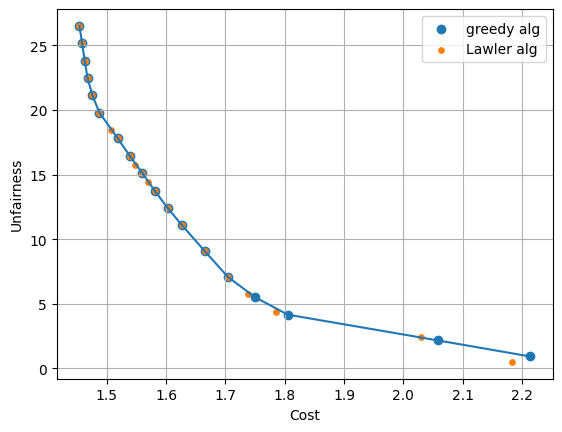

In [58]:
plt.scatter(c_vals, f_vals,label='greedy alg')

#plt.plot(cost_list, fairness_list)
plt.plot(c_vals, f_vals)
plt.scatter(cost_list,fairness_list, label='Lawler alg',s=15)

plt.xlabel("Cost")
plt.ylabel("Unfairness")
plt.legend()
plt.grid()
#plt.savefig('Highschool_tradeoff_Lawlervsgreedy_k5_movingcenters_roundingerrors.pdf')